In [97]:
# 1. Import thư viện
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc as sk_auc

In [98]:
# 2. Load dữ liệu
df = pd.read_csv("final_features_full.csv")
# 5. Tách X (features) và y (label)
X = df.drop("label", axis=1) 
y = df["label"]

In [99]:
# Chuẩn hóa các cột số, không chuẩn hóa các cột đã encoded trong bước tiền xử lý
columns_to_scale = [
    'raised_amount_usd', 'funding_total_usd', 'raised_amount_m', 'raised_amount_b',
    'raised_amount_k', 'num_investors', 'success_rate', 'failure_rate', 'success_amount',
    'fail_amount', 'total_amount', 'avg_funding_per_investor', 'num_of_success_companies',
    'num_of_failed_companies', 'funded_at_year', 'funded_at_month', 'funded_at_day',
    'funding_total_m', 'funding_total_b', 'funding_total_k', 'company_age', 'funding_duration_days',
    'avg_funding_duration_per_round', 'funding_duration_months', 'funding_duration_years',
    'founded_at_year', 'founded_at_month', 'founded_at_day', 'first_funding_year',
    'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month',
    'last_funding_day', 'top_past_sector', 'top_current_sector', 'top_future_sector', 'funding_frequency'
]
scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X[columns_to_scale]), columns=columns_to_scale)
X_remaining = X.drop(columns=columns_to_scale)
X_final = pd.concat([X_scaled_part.reset_index(drop=True), X_remaining.reset_index(drop=True)], axis=1)

In [100]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [101]:
model_names = []
accuracies = []
f1_scores = []
auc_scores = []

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

def plot_cv_evaluation_curves(model_class, X, y, cv, model_params=None, title_prefix="Model"):
    if model_params is None:
        model_params = {}

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions_interp = []
    aps=[]
    mean_recall_interp = np.linspace(0, 1, 100)

    accuracy_list = []
    f1_list = []
    recall_list = []
    precision_list = []

    total_cm = np.array([[0, 0], [0, 0]])
    feature_importances = []

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = model_class(**model_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Tính các metric cơ bản
        accuracy_list.append(accuracy_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred, average='weighted'))
        recall_list.append(recall_score(y_test, y_pred, average='weighted'))
        precision_list.append(precision_score(y_test, y_pred, average='weighted'))

        # Ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        total_cm += cm

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        precision_interp = np.interp(mean_recall_interp, recall[::-1], precision[::-1])
        precisions_interp.append(precision_interp)
        aps.append(average_precision_score(y_test, y_proba))

        # Feature importance
        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

    # Trung bình các metric
    mean_accuracy = np.mean(accuracy_list)
    mean_f1 = np.mean(f1_list)
    mean_recall = np.mean(recall_list)
    mean_precision = np.mean(precision_list)
    mean_auc = np.mean(aucs)
    mean_precision_curve = np.mean(precisions_interp, axis=0)
    mean_ap = np.mean(aps)

    # In kết quả
    print(f"{title_prefix} - Cross-validation average metrics:")
    print(f"Accuracy: {mean_accuracy:.4f}")
    print(f"F1 Score (weighted): {mean_f1:.4f}")
    print(f"Recall (weighted): {mean_recall:.4f}")
    print(f"Precision (weighted): {mean_precision:.4f}")
    print(f"AUC ROC: {mean_auc:.4f}")

    # ROC và PR
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    cm_normalized = total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # ROC
    axes[0, 0].plot(mean_fpr, mean_tpr, color='darkorange', lw=2,
                    label=f'Mean ROC (AUC = {mean_auc:.2f})')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    axes[0, 0].set(xlabel='False Positive Rate', ylabel='True Positive Rate',
                   title=f'{title_prefix} - Mean ROC Curve')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(alpha=0.3)

    # PR Curve
    axes[0, 1].plot(mean_recall_interp, mean_precision_curve, color='blue', lw=2, label=f'Mean PR (AP = {mean_ap:.2f})')
    axes[0, 1].set(xlabel='Recall', ylabel='Precision',
                   title=f'{title_prefix} - Mean Precision-Recall Curve')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend(loc="lower left")

    # Confusion Matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[1, 0])
    axes[1, 0].set(xlabel='Predicted Label', ylabel='True Label',
                   title=f'{title_prefix} - Normalized Confusion Matrix')

    # Feature Importance
    if feature_importances:
        mean_importance = np.mean(feature_importances, axis=0)
        indices = np.argsort(mean_importance)[::-1][:10]
        features = X.columns

        axes[1, 1].bar(range(10), mean_importance[indices], align='center')
        axes[1, 1].set_xticks(range(10))
        axes[1, 1].set_xticklabels([features[i] for i in indices], rotation=45, ha='right')
        axes[1, 1].set_title(f'{title_prefix} - Top 10 Feature Importances')
    else:
        axes[1, 1].text(0.5, 0.5, 'No feature_importances_ attribute',
                        ha='center', va='center', fontsize=12, color='gray')
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': mean_accuracy,
        'f1_score': mean_f1,
        'recall': mean_recall,
        'precision': mean_precision,
        'auc': mean_auc,
        'confusion_matrix': total_cm
    }


Decision Tree - Cross-validation average metrics:
Accuracy: 0.8985
F1 Score (weighted): 0.8988
Recall (weighted): 0.8985
Precision (weighted): 0.8991
AUC ROC: 0.8414


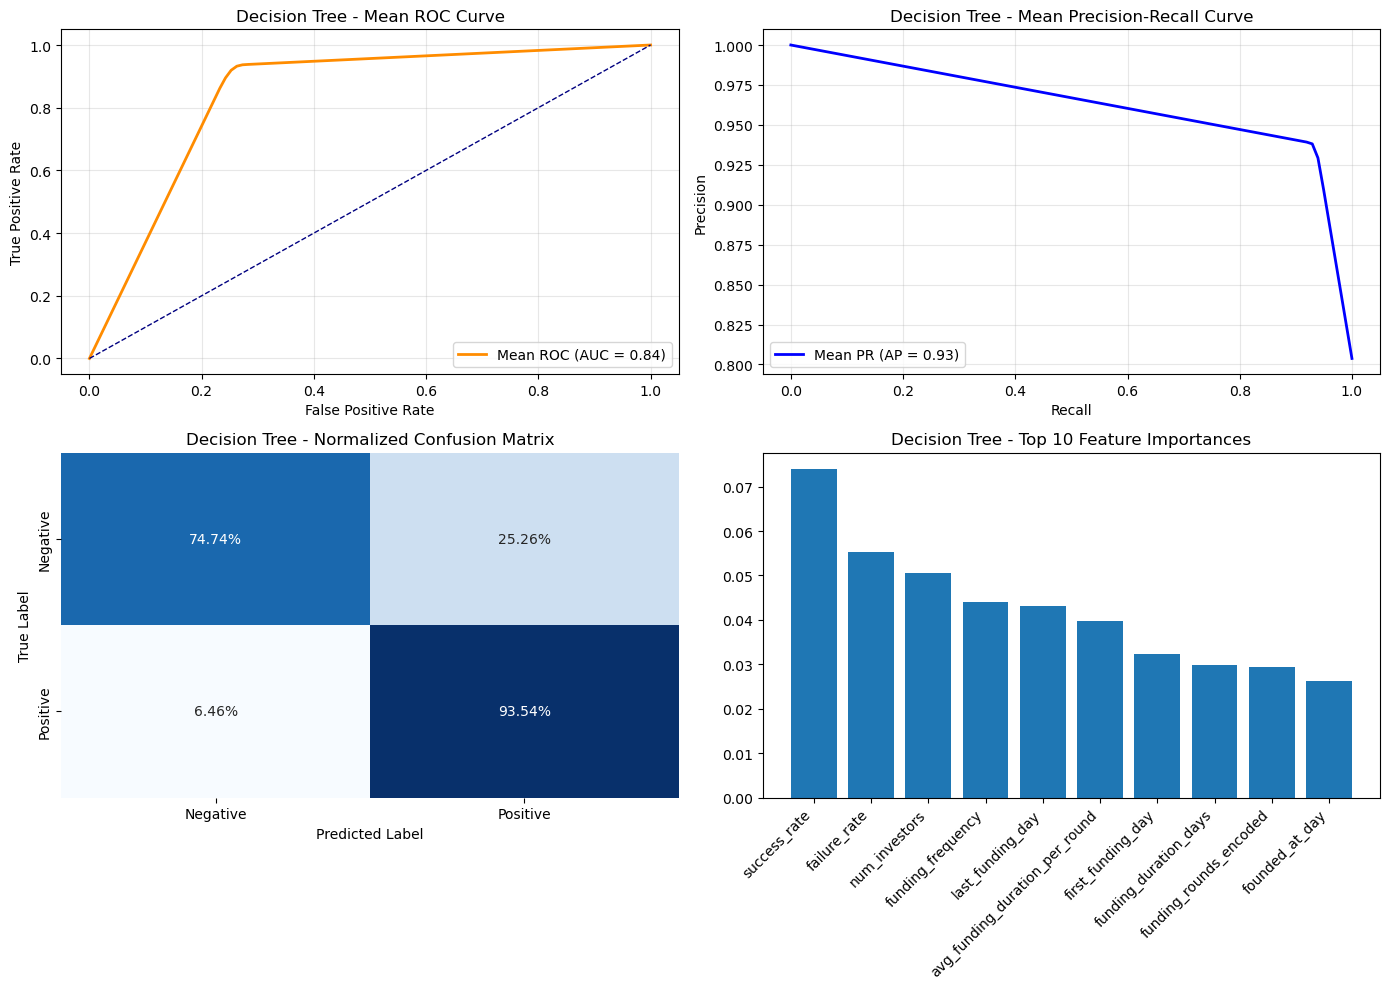

In [103]:
results = plot_cv_evaluation_curves(
    DecisionTreeClassifier, X_final, y, rskf,
    model_params={},  # hoặc ví dụ {"max_depth": 5}
    title_prefix="Decision Tree"
)
model_names.append("Decision Tree (CV)")
accuracies.append(results['accuracy'])
f1_scores.append(results['f1_score'])
auc_scores.append(results['auc'])

XGBoost - Cross-validation average metrics:
Accuracy: 0.9230
F1 Score (weighted): 0.9198
Recall (weighted): 0.9230
Precision (weighted): 0.9209
AUC ROC: 0.9696


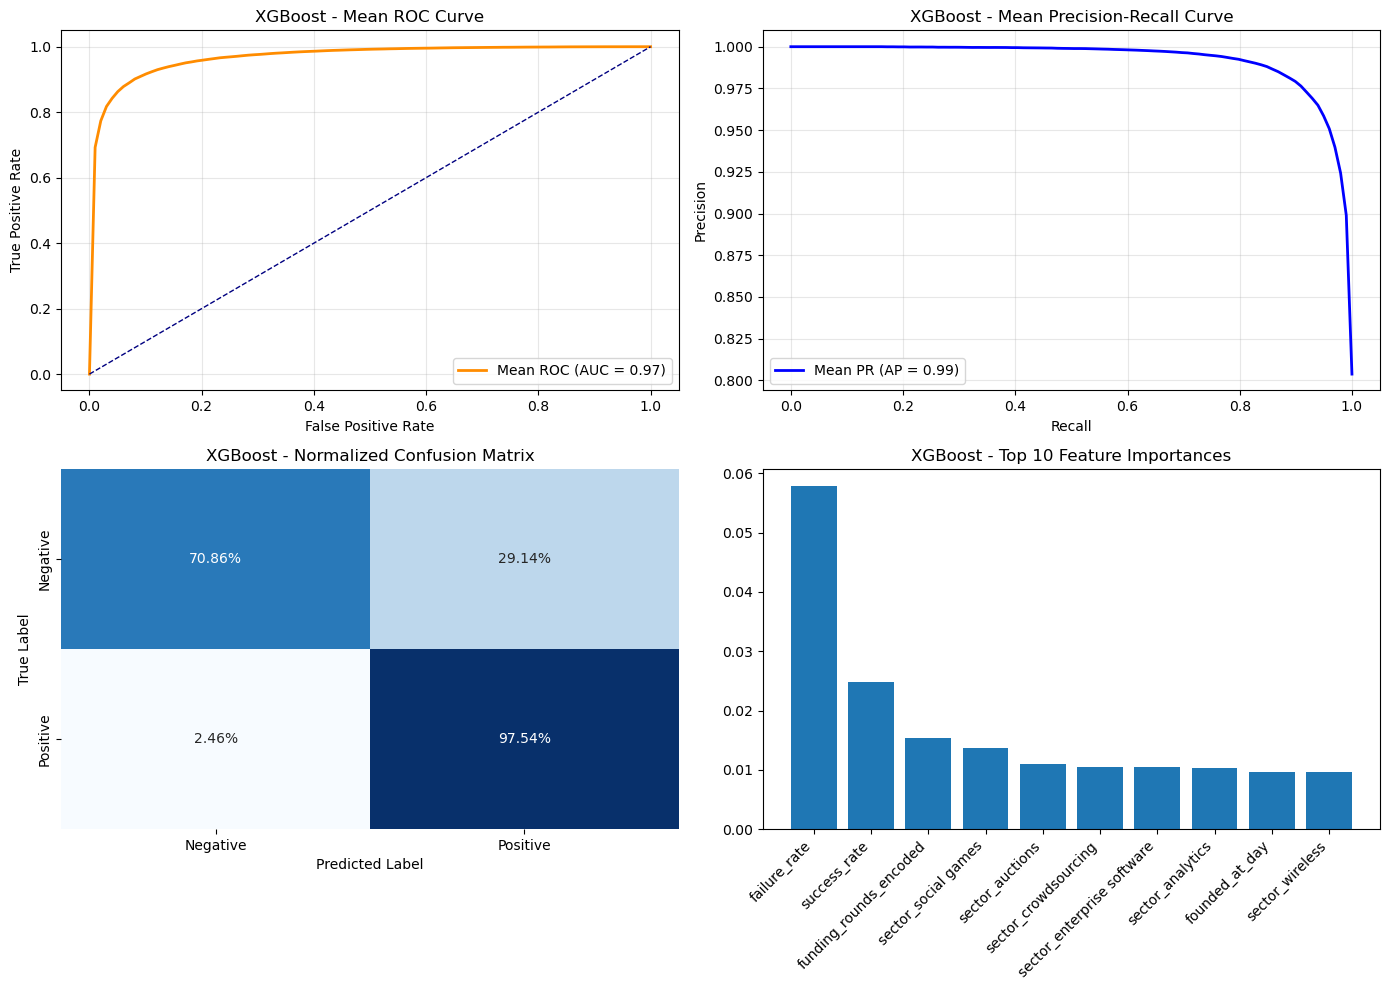

In [104]:
results_xgb = plot_cv_evaluation_curves(
    model_class=xgb.XGBClassifier,
    X=X_final,      # dữ liệu đã chuẩn bị sẵn
    y=y,
    cv=rskf,        # 5x5 Repeated Stratified KFold
    model_params={}, # hoặc thêm param như {"n_estimators": 200}
    title_prefix="XGBoost"
)
model_names.append("XGBoost")
accuracies.append(results_xgb['accuracy'])
f1_scores.append(results_xgb['f1_score'])
auc_scores.append(results_xgb['auc'])

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

AdaBoost - Cross-validation average metrics:
Accuracy: 0.8250
F1 Score (weighted): 0.8009
Recall (weighted): 0.8250
Precision (weighted): 0.8015
AUC ROC: 0.8234


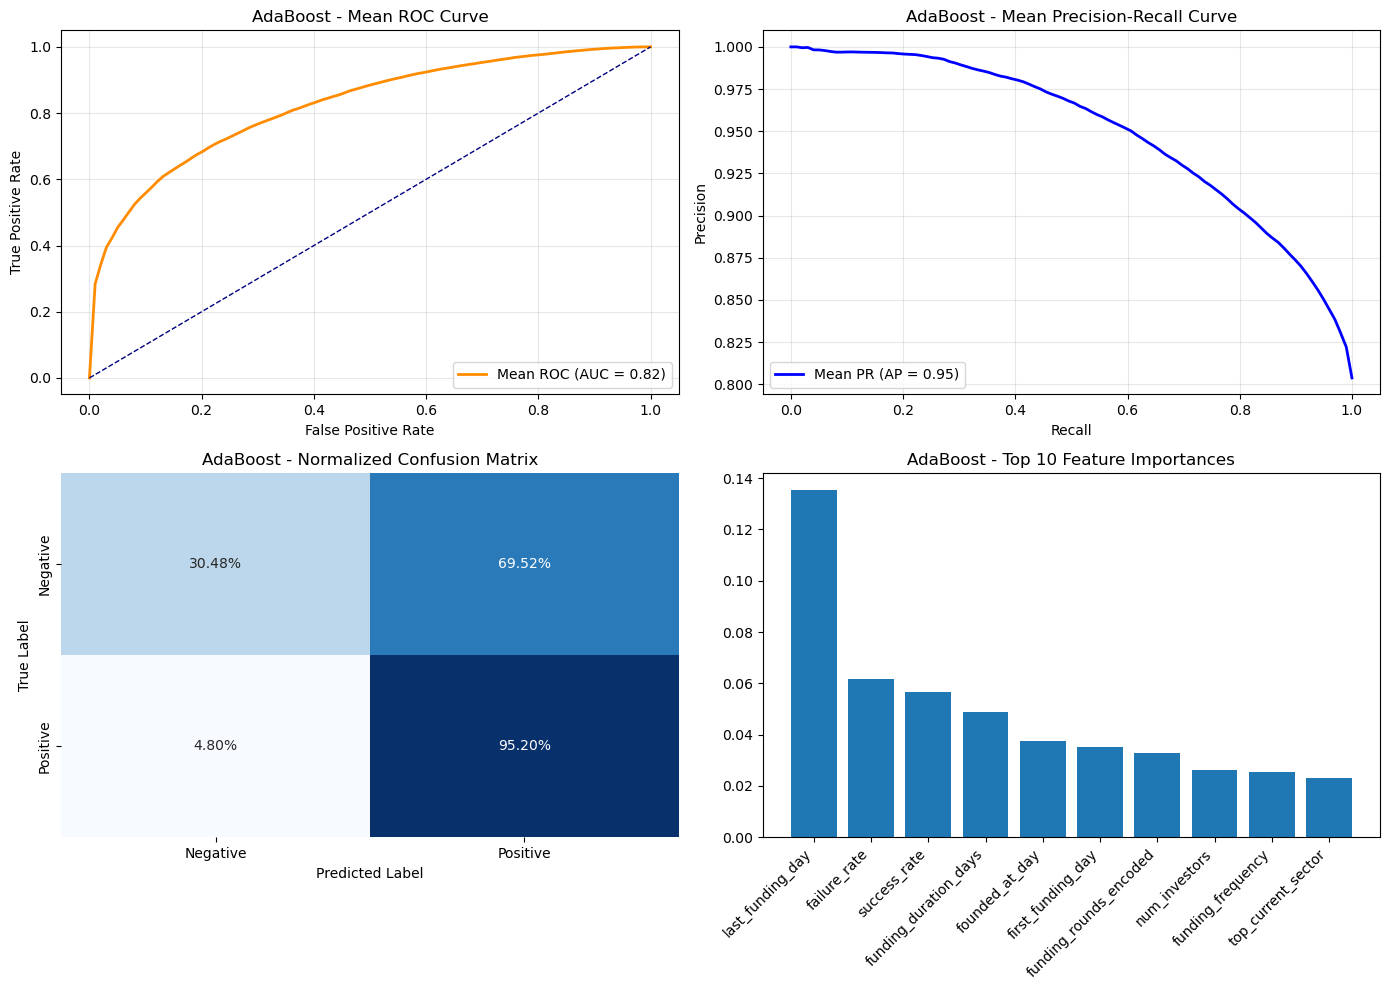

In [105]:
# Áp dụng hàm đã viết trước đó
results_adaboost = plot_cv_evaluation_curves(
    model_class=AdaBoostClassifier,
    X=X_final,
    y=y,
    cv=rskf,  # 5x5 RepeatedStratifiedKFold
    model_params={},  # bạn có thể chỉnh số lượng estimator tại đây
    title_prefix="AdaBoost"
)

# Thêm kết quả vào danh sách để vẽ tổng quan sau này
model_names.append("AdaBoost")
accuracies.append(results_adaboost["accuracy"])
f1_scores.append(results_adaboost["f1_score"])
auc_scores.append(results_adaboost["auc"])

Random Forest - Cross-validation average metrics:
Accuracy: 0.9429
F1 Score (weighted): 0.9407
Recall (weighted): 0.9429
Precision (weighted): 0.9425
AUC ROC: 0.9847


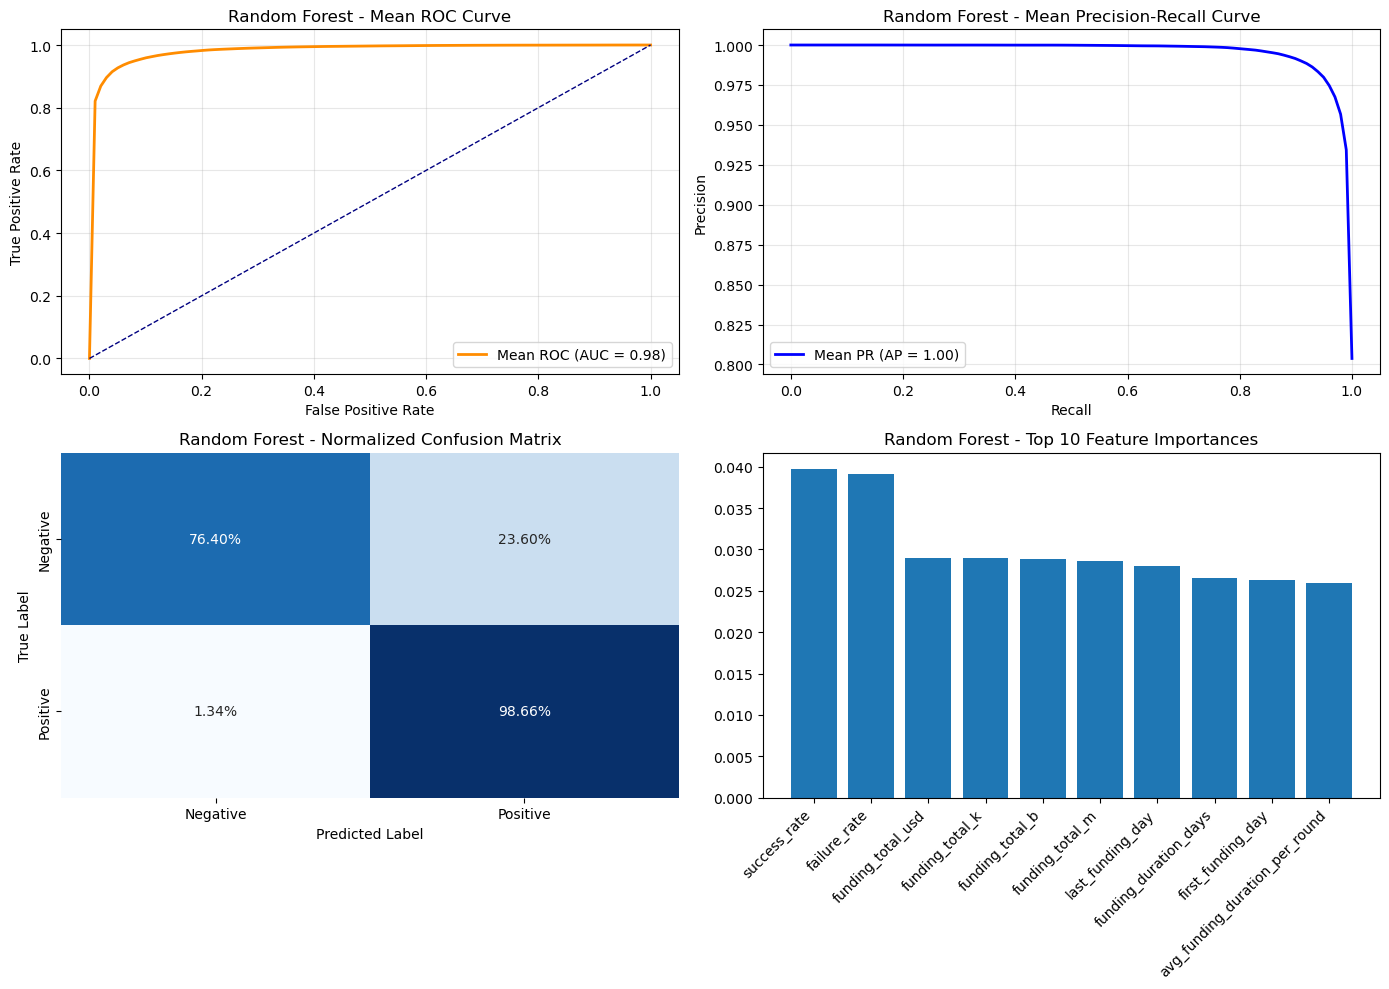

In [106]:
# Đánh giá mô hình Random Forest với 100 cây
results_rf = plot_cv_evaluation_curves(
    model_class=RandomForestClassifier,
    X=X_final,
    y=y,
    cv=rskf,  # RepeatedStratifiedKFold 5x5 bạn đã khai báo từ trước
    model_params={"n_estimators": 100},  # Số lượng cây là 100
    title_prefix="Random Forest"
)

# Lưu kết quả vào danh sách để sau này vẽ tổng quan
model_names.append("Random Forest 100 trees")
accuracies.append(results_rf["accuracy"])
f1_scores.append(results_rf["f1_score"])
auc_scores.append(results_rf["auc"])

Random Forest - Cross-validation average metrics:
Accuracy: 0.9432
F1 Score (weighted): 0.9409
Recall (weighted): 0.9432
Precision (weighted): 0.9430
AUC ROC: 0.9857


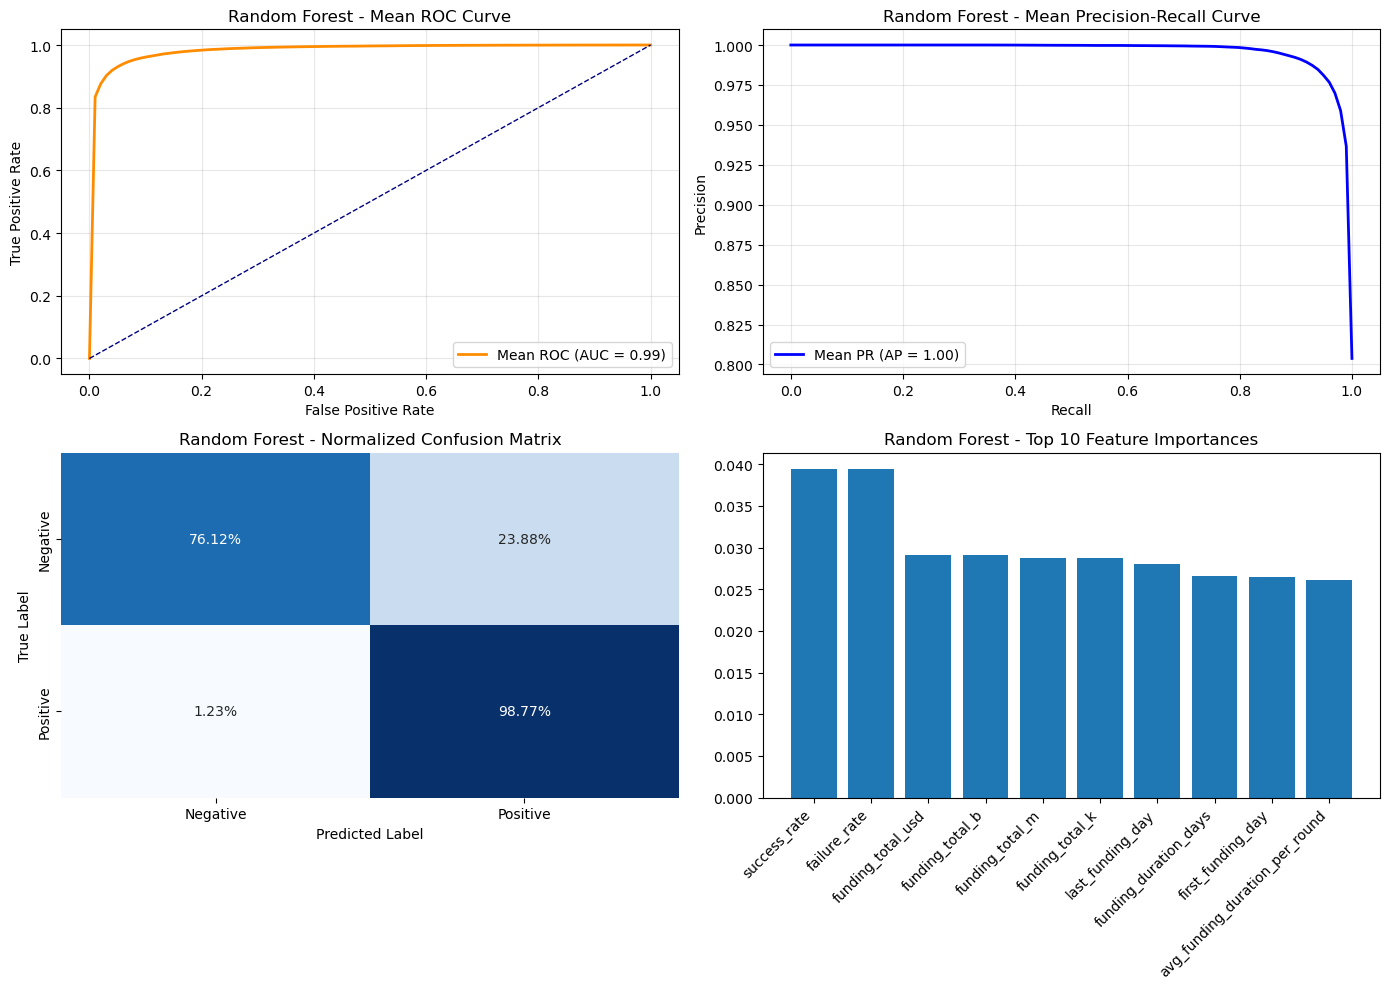

In [118]:
# Đánh giá mô hình Random Forest với 200 cây
results_rf = plot_cv_evaluation_curves(
    model_class=RandomForestClassifier,
    X=X_final,
    y=y,
    cv=rskf,  # RepeatedStratifiedKFold 5x5 bạn đã khai báo từ trước
    model_params={"n_estimators": 200},  # Số lượng cây là 100
    title_prefix="Random Forest"
)

# Lưu kết quả vào danh sách để sau này vẽ tổng quan
model_names.append("Random Forest 200 trees")
accuracies.append(results_rf["accuracy"])
f1_scores.append(results_rf["f1_score"])
auc_scores.append(results_rf["auc"])

KNN (k=5) - Cross-validation average metrics:
Accuracy: 0.8919
F1 Score (weighted): 0.8899
Recall (weighted): 0.8919
Precision (weighted): 0.8888
AUC ROC: 0.9242


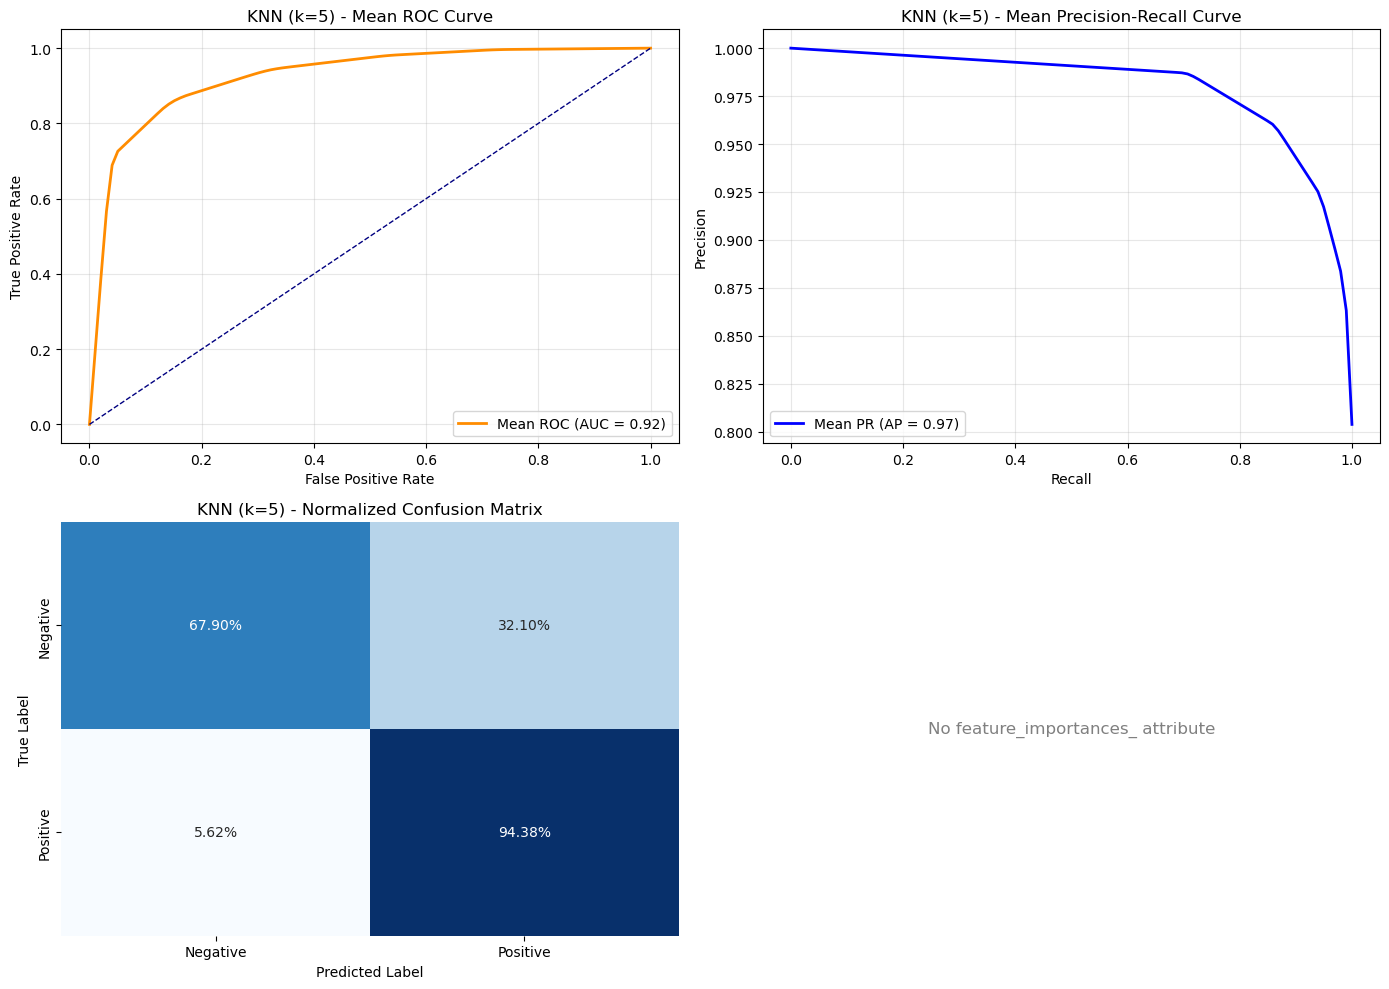

In [120]:
# Gọi hàm đánh giá cho KNN với k = 5
results_knn = plot_cv_evaluation_curves(
    model_class=KNeighborsClassifier,
    X=X_final,
    y=y,
    cv=rskf,
    model_params={"n_neighbors": 5},
    title_prefix="KNN (k=5)"
)

# Lưu kết quả vào danh sách tổng hợp
model_names.append("KNN (k=5)")
accuracies.append(results_knn['accuracy'])
f1_scores.append(results_knn['f1_score'])
auc_scores.append(results_knn['auc'])

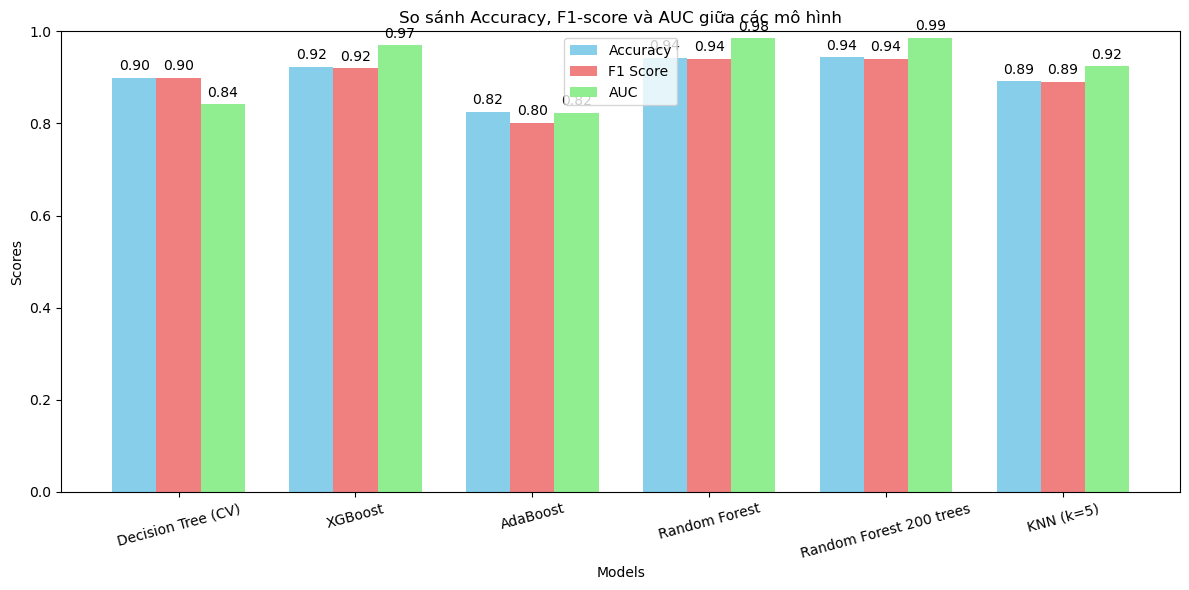

In [122]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(model_names))  # vị trí các mô hình
width = 0.25  # thu hẹp độ rộng để vừa 3 cột

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, accuracies, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x, f1_scores, width, label='F1 Score', color='lightcoral')
bars3 = ax.bar(x + width, auc_scores, width, label='AUC', color='lightgreen')

# Gán nhãn trục và tiêu đề
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('So sánh Accuracy, F1-score và AUC giữa các mô hình')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.legend()
ax.set_ylim(0, 1)

# Ghi số lên đầu cột
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
